# PixelCNN

PixelCNN, like MADE, is a masking-based autoregressive model, is a masking-based autoregressive model introduced in the paper "Pixel Recurrent Neural Networks" by Aaron van den Oord in 2016. As its name implies, PixelCNN applies a special mask on the convolutional filters to ensure that the prediction for each pixel is dependent only on the previously observed pixels and not on future ones. 

<div style="display: flex; justify-content: center;">
 <img src="/Users/raymondtsao/Desktop/UnsupervisedLearningNotes/notes/Autoregressive/figures/pixelcnn_intro.png" style="max-width: 35%; height: auto;">  
</div>

<p style="text-align: center; font-size: 14px; margin-top: 20px;"> 
    <strong> Figure 1 </strong>: Example of PixelCNN convolutional filter with kernel size 5. The current pixel (pixel 13) is only allowed to depend on previous pixels (pixel 1-12). Future pixels (pixel 14-25) are masked by setting the convolutional filters to 0. 
</p>

In the paper, Oord proposed two types of masks: Type A and Type B. The Type A mask ensures that the current pixel can only depend on previously processed pixels. In contrast, the Type B mask allows the current pixel to depend on both previous pixels and the same pixel in the current layer. The idea behind this design is that once the Type A mask is applied in the initial layer, the autoregressive property is enforced, therefore there is no need to block information flow in the subsequent layers.

<div style="display: flex; justify-content: center;">
 <img src="/Users/raymondtsao/Desktop/UnsupervisedLearningNotes/notes/Autoregressive/figures/pixelcnn_mask.png" style="max-width: 40%; height: auto;">  
</div>

<p style="text-align: center; font-size: 14px; margin-top: 20px;"> 
    <strong> Figure 2 </strong>: Type A and type B mask. The blue regions are set to 1, while the gray regions are set to 0. 
</p>

## PixelCNN Architechture

Masked convolutional filters are the fundamental building blocks of PixelCNN. In the paper, the author stacks these filters according to the residual block architecture. Each residual block is followed by batch normalization and a ReLU activation function. The final output layer consists of a single convolutional filter with an output channel dimension of `input_channel_dimension` $\times$ `num_classes`. The resulting output is then reshaped to produce the logits for the image.

<div style="display: flex; justify-content: center;">
 <img src="/Users/raymondtsao/Desktop/UnsupervisedLearningNotes/notes/Autoregressive/figures/pixelcnn_resblock.png" style="max-width: 40%; height: auto;">  
</div>

<p style="text-align: center; font-size: 14px; margin-top: 20px;"> 
    <strong> Figure 3 </strong>: Architecture of PixelCNN. The output shape of each block is shown below. We stack K residual blocks, each containing 3 masked convolutional filters with type B mask. The kernel size of the filters are 1, 7, and 1, respectively. The number of channel is also reduced by half in the middle filter.
</p>

In the following section, we will implement PixelCNN from scratch and evaluate its performance on both binarized and colored MNIST data. The colored MNIST data is sourced from the Berkeley CS294-158 Deep Unsupervised Learning course HW1. The colors in this dataset are encoded with 4 bits, which makes it easier to model compared to the standard 8-bit color encoding.

## PixelCNN Implementation

### Masked Convolution Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pickle
from torch.utils.data import TensorDataset, DataLoader
from PixelCNN import *

DEVICE =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

file_path = '/content/drive/MyDrive/Deep unsupervised learning/Autoregressive/data/mnist_colored.pkl'
with open(file_path, 'rb') as f:
    mnist_colored = pickle.load(f)
x_train = mnist_colored['train']
x_test = mnist_colored['test']
train_dataset = TensorDataset(torch.tensor(x_train).permute(0, 3, 1, 2))
test_dataset = TensorDataset(torch.tensor(x_test).permute(0, 3, 1, 2))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [38]:
class MaskedConv2d(nn.Module):
    """
    Implementation of masked convolution layer
    """
    def __init__(self, in_channels, out_channels, kernel_size, mask_type="A", device=DEVICE):
        """
        @param in_channels, out_channels, kernel_size: int
        @param mask_type
            Accepts type "A" or "B" (see figure 1 and 2)
        @ param device: string
        """
        super(MaskedConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2)
        self.set_mask(kernel_size, mask_type, device)

    def set_mask(self, kernel_size, mask_type, device):
        """
        PixelCNN mask setup 
        """
        self.mask = torch.ones(self.conv.weight.shape, device=device, requires_grad=False).float()
        self.mask[:, :, 1 + kernel_size // 2:, :] = 0.0
        self.mask[:, :, kernel_size // 2, 1 + kernel_size // 2:] = 0.0
        if mask_type == "A":
            self.mask[:, :, kernel_size // 2, kernel_size // 2] = 0.0

    def forward(self, x):
        """
        @param x: torch.tensor [B, C, H, W]
        """
        self.conv.weight.data *= self.mask
        return self.conv(x)
    
class ResidualBlock(nn.Module):
    """
    Implementation of residual block with fixed mask type B
    """
    def __init__(self, in_channels):
        """
        @param in_channels: int
        """
        super(ResidualBlock, self).__init__()
        self.net = nn.Sequential(MaskedConv2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=1, mask_type="B"),
                                 nn.ReLU(),
                                 MaskedConv2d(in_channels=in_channels//2, out_channels=in_channels//2, kernel_size=7, mask_type="B"),
                                 nn.ReLU(),
                                 MaskedConv2d(in_channels=in_channels//2, out_channels=in_channels, kernel_size=1, mask_type="B"))

    def forward(self, x):
        """
        @param x: torch.tensor [B, C, H, W]
        """
        out = self.net(x)
        return x + out

### PixelCNN Implementation

In [ ]:
class PixelCNN(nn.Module):
    """
    Implementation of PixelCNN for both grayscale and colored images
    """
    def __init__(self, in_channels, hidden_channels, n_classes, n_layers, height, width, color_independent=True):
        """
        @param in_channels, hidden_channels: int
        @param n_classes: int
            Number of output classes
        @param n_layers: int
            Number of Residual block layers
        @param height, width: int
        @param color_independent: boolean
            True if assume color channels are independent (default True)
        """
        super(PixelCNN, self).__init__()
        self.net = [MaskedConv2d(in_channels, hidden_channels, kernel_size=7, mask_type="A"),
                    nn.BatchNorm2d(hidden_channels),
                    nn.ReLU()]
        for _ in range(n_layers):
            self.net.extend([ResidualBlock(hidden_channels),
                             nn.BatchNorm2d(hidden_channels),
                             nn.ReLU()])
        self.net.append(MaskedConv2d(hidden_channels, in_channels*n_classes, kernel_size=1, mask_type="B"))
        self.net = nn.ModuleList(self.net)
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.height = height
        self.width = width
        self.color_independent = color_independent

    def forward(self, x):
        """
        @param x: torch.tensor [B, C, H, W]
        """
        x = (x.float() / (self.n_classes - 1) - 0.5) / 0.5
        for layer in self.net:
            x = layer(x)
        if self.color_independent:
            x = x.view(x.shape[0], self.n_classes, self.in_channels, x.shape[2], x.shape[3])
        else:
            x = x.view(x.shape[0], self.in_channels, self.n_classes, x.shape[2], x.shape[3]).permute(0, 2, 1, 3, 4)
        return x

    def sample(self, n_samples, device):
        """
        @param n_samples: int
            Number of samples to geneerate
        @param device: string
        """
        self.eval()
        with torch.no_grad():
            sample = torch.zeros(n_samples, self.in_channels, self.height, self.width).to(device).float()
            for i in range(self.height):
                for j in range(self.width):
                    for c in range(self.in_channels):
                        out = self.forward(sample)
                        logits = out[:, :, c, i, j]
                        prob = nn.Softmax(dim=1)(logits)
                        sample[:, c, i, j] = torch.multinomial(prob, 1).squeeze(-1)
            sample = sample.permute(0, 2, 3, 1)
            sample = sample.detach().cpu().numpy()
            sample = sample.astype(np.float32)
        return sample

## Grayscale MNIST 

After implementing the PixelCNN, we tested it on the binarized MNIST dataset. We trained a PixelCNN with hidden channels set to $120$. We stacked $8$ layers of residual blocks. The model is trained for around $10$ epochs using Adam optimizer with learning rate of $10^{-3}$. The generated image is shown below.

In [47]:
pixelcnn = PixelCNN(in_channels=1, hidden_channels=120, n_classes=2, n_layers=8, height=28, width=28).to(DEVICE)
optimizer = optim.Adam(pixelcnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train(pixelcnn, train_loader, test_loader, optimizer, criterion, 10, DEVICE)

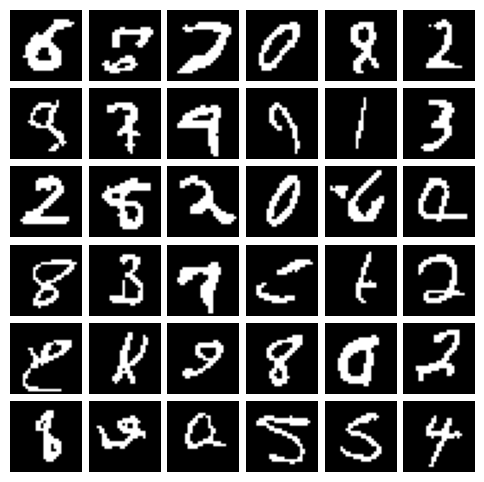

In [46]:
plot_samples(pixelcnn, 36, DEVICE)

## Colored MNIST: Independent Channels

We now consider the case with multiple color channels. One approach is to treat each color channel as independent and model each channel separately. Formally, we model:

$$p_{\theta}(\mathbf{x}) = \prod_{i=1}^{HW}\prod_{c=1}^{C} p_{\theta}(x_i^c|x_{<i})$$

In this case, there is no need to change our original implementation except for adjusting the input channels to match the number of color channels. We use the same architecture as in the grayscale MNIST case and test the model on the colored MNIST dataset with 4-bit color encoding. The generated samples are shown below. Note that the model is once again able to learn the colored handwritten digits.

In [26]:
pixelcnn = PixelCNN(in_channels=3, hidden_channels=120, n_classes=4, n_layers=8, height=28, width=28).to(DEVICE)
optimizer = optim.Adam(pixelcnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train(pixelcnn, train_loader, test_loader, optimizer, criterion, 10, DEVICE)

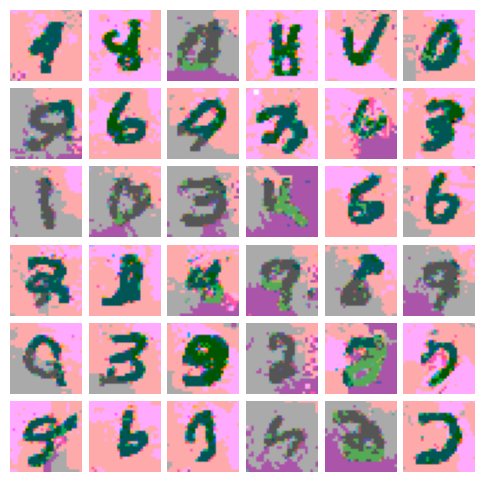

In [27]:
plot_samples(pixelcnn, 36, DEVICE)

## Colored MNIST: Dependent Color Channels

We can also drop the independence assumption and model dependent color channels

$$p_{\theta}(\mathbf{x}) = \prod_{i=1}^{HW}\prod_{c=1}^{C} p_{\theta}(x_i^c|x_{i}^{<c}, x_{<i})$$

In this case, we need to modify our masking scheme slightly. 

In [22]:
class MaskedConv2d(nn.Module):
    """
    Implementation of masked convolution layer assuming color channels are dependent
    """
    def __init__(self, in_channels, out_channels, kernel_size, mask_type="A", device=DEVICE):
        """
        @param in_channels, out_channels, kernel_size: int
        @param mask_type
            Accepts type "A" or "B" (see figure 1 and 2)
        @ param device: string
        """
        super(MaskedConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2)
        self.set_mask(kernel_size, mask_type, device)

    def set_mask(self, kernel_size, mask_type, device):
        """
        PixelCNN mask setup 
        """
        out_dim, in_dim = self.conv.weight.shape[:2]
        self.mask = torch.ones(self.conv.weight.shape, device=device, requires_grad=False).float()
        one_third_in_dim, one_third_out_dim = in_dim // 3, out_dim // 3

        self.mask[:, :, 1 + kernel_size // 2:, :] = 0.0
        self.mask[:, :, kernel_size // 2, 1 + kernel_size // 2:] = 0.0
        self.mask[:one_third_out_dim, one_third_in_dim:, kernel_size // 2, kernel_size // 2] = 0.0
        self.mask[one_third_out_dim:2*one_third_out_dim, 2*one_third_in_dim:, kernel_size // 2, kernel_size // 2] = 0.0
        self.mask[2*one_third_out_dim:, 3*one_third_in_dim:, kernel_size // 2, kernel_size // 2] = 0.0

        if mask_type == "A":
            self.mask[:one_third_out_dim, :one_third_in_dim, kernel_size // 2, kernel_size // 2] = 0.0
            self.mask[one_third_out_dim:2*one_third_out_dim, one_third_in_dim:2*one_third_in_dim, kernel_size // 2, kernel_size // 2] = 0.0
            self.mask[2*one_third_out_dim:, 2*one_third_in_dim:3*one_third_in_dim, kernel_size // 2, kernel_size // 2] = 0.0

    def forward(self, x):
        """
        @param x: torch.tensor [B, C, H, W]
        """
        self.conv.weight.data *= self.mask
        return self.conv(x)

We tested PixelCNN with dependent color channels using the same architecture and hyperparameter setting as above. The generated image is shown below. The generated image seems to be smoother and less noisy compared to the case of independent color channels.

In [ ]:
pixelcnn = PixelCNN(in_channels=3, hidden_channels=120, n_classes=4, n_layers=8, height=28, width=28, color_independent=False).to(DEVICE)
optimizer = optim.Adam(pixelcnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train(pixelcnn, train_loader, test_loader, optimizer, criterion, 10, DEVICE)

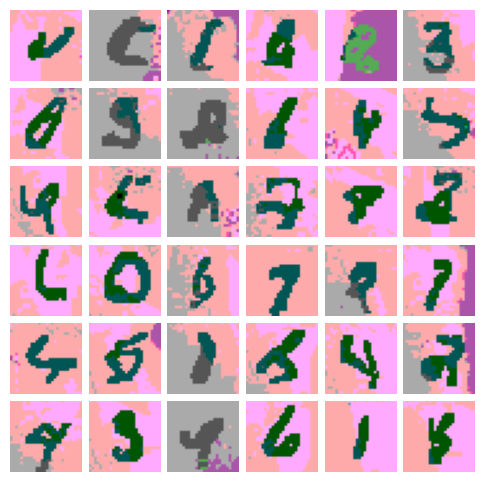

In [24]:
plot_samples(pixelcnn, 36, DEVICE)